

# Introduction

The purpose of this .ipynb is to generate Tead single motif pairing with all the motifs in-silico predicted binding of Yap1 using `TSC model`. This will allow us to assess which motifs influence Yap1 binding at Tead single motifs.

# Computational setup





In [4]:
import warnings
warnings.filterwarnings("ignore")
from tensorflow.python.util import deprecation
deprecation._PRINT_DEPRECATION_WARNINGS = False

#Packages
import os
import sys
import random
import pandas as pd
import numpy as np
from tqdm import tqdm
from pybedtools import BedTool
from bpnet.BPNet import BPNetSeqModel
from bpnet.simulate import insert_motif

# Settings
os.chdir(f'/n/projects/kd2200/publication/bpnet/analysis/')
pd.set_option('display.max_columns', 100)


# Custom commands
sys.path.insert(0, f'/n/projects/kd2200/publication/bpnet/analysis/scripts/bpnet/scripts')
from data_format_functions import myround, myfloor, myceiling
#from bpnet_motif_functions import one_hot_encode_sequences


# Get tsc model directory
model_dir = f"/n/projects/kd2200/publication/bpnet/model/dataspec.yaml_default_fold_5/"

#Pre-existing variables
motif_seqs = {
    'tead4': 'ACATTCCTG',
    'tfap2c': 'CCCTCAGGC',
    'cdx2': 'GCCATAAA',
    'gata3': 'AGATAAG',
    'junfos': 'ATGAGTCAT',
    'ctcf': 'CCACTAGGGGGCG',
    'elf5': 'CCGGAAG',
    'gata3_double': 'AGATAAGATCT',
    'tead4_double': 'ACATTCCTGGCATTCC'
}

motif_colors = {
    "tead4": "#007d47",
    "tfap2c": "#c22f2f",
     "yap1": "#14a0b5",  
     "cdx2": "#E69F00",
     "gata3": "#3600e6",
}

# Collect in silico interaction analysis

Here, we will collect (1) for every motif, (2) across every motif-motif center-to-center distance of 5-400bp, (3) over 64 trials per combination of (1) and (2) the in silico predictions of every task for these situations. Because this is a large number of predictions, `36x395x64`, we want to use the GPU. The below script and associated Python script `bpnet_generate_in_silico_data.py` has the code necessary to generate these collections. The returned outcome will be a large `tsv.gz` tidied data.frame of the prediction scores.

In [2]:
#%%script false --no-raise-error
!qsub scripts/bpnet_generate_in_silico_data.sge

TF-MoDISco is using the TensorFlow backend.


# Import in silico intertaction analysis

Read in the summaries after they are generated and assign motif pair names and information for simultaneous plotting.

In [5]:
dfs_all = pd.read_csv(f'tsv/insilico_summaries.tsv.gz', sep = '\t')
dfs_all.head(n=5)

,Unnamed: 0,profile/simmetric_kl,profile/counts,profile/counts_frac,profile/max,profile/max_frac,profile/counts_max_ref,profile/counts_max_ref_frac,task,central_motif,side_motif,position,distance
0,0,0.009797,2.835840,0.950076,0.040377,0.826658,0.075808,0.834862,cdx2,tead4,tfap2c,505,5
1,1,inf,0.147761,0.136622,0.040354,1.836036,0.053562,1.387818,tfap2c,tead4,tfap2c,505,5
2,2,0.094784,2.526328,0.414038,0.133172,0.217763,0.220702,0.270095,tead4,tead4,tfap2c,505,5
3,3,0.020332,1.086709,0.730384,0.021574,0.373952,0.038003,0.467015,yap1,tead4,tfap2c,505,5
4,4,0.054657,0.928262,1.002439,0.015983,0.898158,0.019664,0.687355,gata3,tead4,tfap2c,505,5


In [6]:
#Assign motif_pair names for faceting
motif_pair = []
for i in range(dfs_all.shape[0]):
    if dfs_all.central_motif.iloc[i] > dfs_all.side_motif.iloc[i]:
        val = dfs_all.side_motif.iloc[i] + '_' + dfs_all.central_motif.iloc[i]
        motif_pair.append(val)
    else:
        val = dfs_all.central_motif.iloc[i] + '_' + dfs_all.side_motif.iloc[i]
        motif_pair.append(val)
dfs_all['motif_pair'] = motif_pair
dfs_all['motif_pair_raw'] = dfs_all.central_motif + '_' + dfs_all.side_motif

#Mark the BPNet tasks as 'featured' for plotting
featured_idx = [row.task in row.central_motif for idx,row in dfs_all.iterrows()]
dfs_all['featured_task'] = featured_idx

#Make categorigal variable column
dfs_all['task'] = pd.Categorical(dfs_all['task'], categories = list(motif_colors.keys()), ordered = False)
dfs_all.head(n=4)

,Unnamed: 0,profile/simmetric_kl,profile/counts,profile/counts_frac,profile/max,profile/max_frac,profile/counts_max_ref,profile/counts_max_ref_frac,task,central_motif,side_motif,position,distance,motif_pair,motif_pair_raw,featured_task
0,0,0.009797,2.835840,0.950076,0.040377,0.826658,0.075808,0.834862,cdx2,tead4,tfap2c,505,5,tead4_tfap2c,tead4_tfap2c,False
1,1,inf,0.147761,0.136622,0.040354,1.836036,0.053562,1.387818,tfap2c,tead4,tfap2c,505,5,tead4_tfap2c,tead4_tfap2c,False
2,2,0.094784,2.526328,0.414038,0.133172,0.217763,0.220702,0.270095,tead4,tead4,tfap2c,505,5,tead4_tfap2c,tead4_tfap2c,True
3,3,0.020332,1.086709,0.730384,0.021574,0.373952,0.038003,0.467015,yap1,tead4,tfap2c,505,5,tead4_tfap2c,tead4_tfap2c,False


In [ ]:
# Save tsv 
dfs_all.to_csv(f"tsv/4b_cttygjectg_bothdouble_insilico_distance_analysis.tsv", sep="\t")

In [7]:
# filter distance and Yap1 task to summarize values

dfs2_all= dfs_all[(dfs_all["distance"] >= 25) & (dfs_all["distance"] <= 150)].reset_index()
summary_df = dfs2_all.groupby(['task','central_motif', 'side_motif'])['profile/counts_frac','profile/counts_max_ref_frac'].mean().reset_index()
summary_df['log2_fc_sum_cooperativity'] = np.log2(summary_df['profile/counts_frac'])
summary_df['log2_fc_max_cooperativity'] = np.log2(summary_df['profile/counts_max_ref_frac'])

df= summary_df[(summary_df["central_motif"] == 'tead4') & (summary_df["task"] == 'yap1')].reset_index()
df2 = df.sort_values(by='log2_fc_sum_cooperativity', ascending=False).reset_index()
df2['side_motif'] = pd.Categorical(df2['side_motif'], ordered=True, categories=['tead4_double','tead4','junfos','tfap2c','ctcf','elf5','gata3','cdx2','gata3_double'])



In [ ]:
# Save tsv summary for yap1 and then plot in R
df2.to_csv(f"tsv/4b_yaptask_summary_cttygjectg_bothdouble_insilico_distance_analysis.tsv", sep="\t")

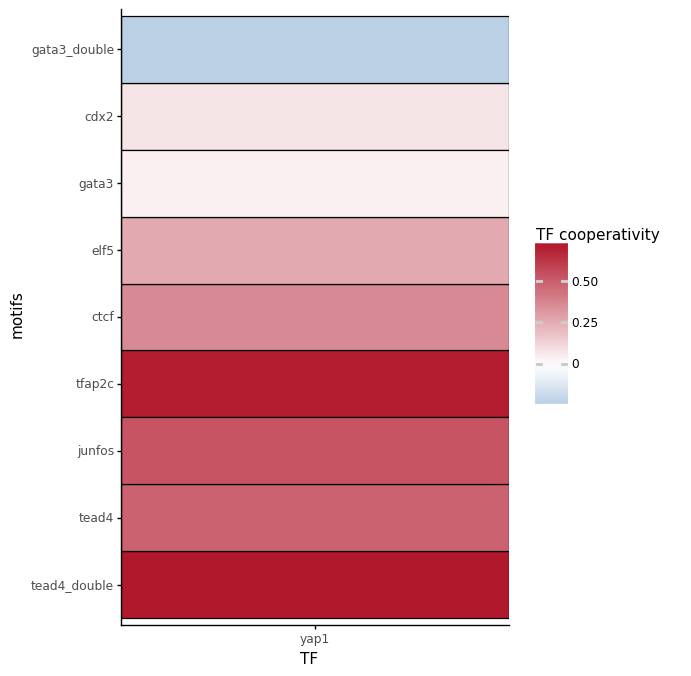

<ggplot: (8787647360930)>

In [8]:
#quick plotting to see.
import plotnine
from plotnine import *
plotnine.options.figure_size = (5, 8)

g =(ggplot(data = df2, mapping = aes(x = 'task', y = 'side_motif', fill = 'log2_fc_max_cooperativity'))+
    geom_tile(color = 'black', size = .5)+
    scale_x_discrete(name = 'TF')+
    scale_y_discrete(name = 'motifs')+
    scale_fill_gradient2(name = 'TF cooperativity ', high = '#b2182b', low = '#2166ac', mid = 'white', midpoint = 0)+
    theme_classic())
g